# Wildfire Detection using PyTorch

University of Texas at Dallas

CS 4391.001 Intro to Computer Vision

Professor: Yapeng Tian

## 1. Read Data

Specify the path to each directory, and set each directory as a variable.

In [1]:
# Specify Path to the dataset
import os

base_path = "archive/the_wildfire_dataset/the_wildfire_dataset"
# Path to the dataset

# sub folders
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
val_path = os.path.join(base_path, "val")


fire = "fire"
# Subclass for fire
both_smoke_and_fire = "Both_smoke_and_fire"
smoke_from_fires = "Smoke_from_fires"

nofire = "nofire"
# Subclass for nofire
fire_confounding_elements = "Fire_confounding_elements"
forested_areas_without_confounding_elements = "Forested_areas_without_confounding_elements"
smoke_confounding_elements = "Smoke_confounding_elements"

# Example of a path to a fire image
# "archive/the_wildfire_dataset/the_wildfire_dataset/train/fire/Both_smoke_and_fire/xxxxx.jpg"

## 2. Visualize the Data

Check how much images are available for each dataset.

In [8]:
import pandas as pd

data_size = pd.DataFrame(columns=["Train", "Test", "Val"])

# Show the number of images in each subclass
for subclass in [fire, nofire]:
    for subsubclass in os.listdir(os.path.join(train_path, subclass)):
        data_size.loc[subsubclass, "Train"] = len(os.listdir(os.path.join(train_path, subclass, subsubclass)))
        data_size.loc[subsubclass, "Test"] = len(os.listdir(os.path.join(test_path, subclass, subsubclass)))
        data_size.loc[subsubclass, "Val"] = len(os.listdir(os.path.join(val_path, subclass, subsubclass)))

data_size

,Train,Test,Val
Both_smoke_and_fire,269,59,57
Smoke_from_fires,461,100,99
Fire_confounding_elements,236,52,50
Forested_areas_without_confounding_elements,591,128,127
Smoke_confounding_elements,330,71,69


Display the first image of each category

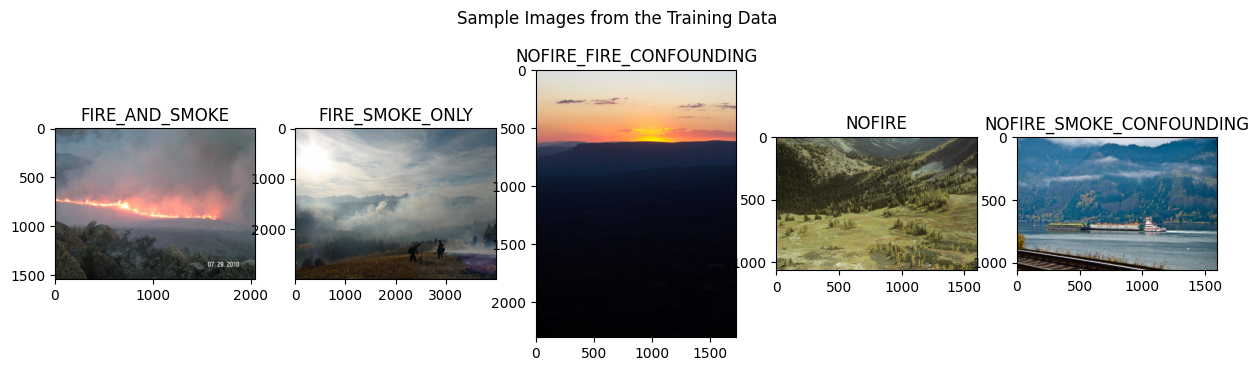

In [9]:
import matplotlib.pyplot as plt

# Set figure
fig,ax=plt.subplots(1,5, figsize=(15,4))

# plot sample images from each subclass
ax[0].imshow(plt.imread(os.path.join(train_path, fire, both_smoke_and_fire, os.listdir(os.path.join(train_path, fire, both_smoke_and_fire))[0])))
ax[0].set_title(f"FIRE_AND_SMOKE")
ax[1].imshow(plt.imread(os.path.join(train_path, fire, smoke_from_fires, os.listdir(os.path.join(train_path, fire, smoke_from_fires))[0])))
ax[1].set_title(f"FIRE_SMOKE_ONLY")
ax[2].imshow(plt.imread(os.path.join(train_path, nofire, fire_confounding_elements, os.listdir(os.path.join(train_path, nofire, fire_confounding_elements))[0])))
ax[2].set_title(f"NOFIRE_FIRE_CONFOUNDING")
ax[3].imshow(plt.imread(os.path.join(train_path, nofire, forested_areas_without_confounding_elements, os.listdir(os.path.join(train_path, nofire, forested_areas_without_confounding_elements))[0])))
ax[3].set_title(f"NOFIRE")
ax[4].imshow(plt.imread(os.path.join(train_path, nofire, smoke_confounding_elements, os.listdir(os.path.join(train_path, nofire, smoke_confounding_elements))[0])))
ax[4].set_title(f"NOFIRE_SMOKE_CONFOUNDING")


plt.suptitle("Sample Images from the Training Data")
plt.show()

## 3. Initialize PyTorch

Check if PyTorch is installed, and check if cuda is available

In [2]:
import torch

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set the seed for reproducible results
torch.manual_seed(42)

Using device: cuda:0


## 4. Prepare the Data

In [3]:
# Define the transforms
from torchvision import datasets
from torchvision import transforms

# Define the transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# Define the datasets
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(test_path, transform=test_transforms)
val_data = datasets.ImageFolder(val_path, transform=val_transforms)

# Define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

# Define the classes
classes = train_data.classes
classes

['fire', 'nofire']

In [4]:
# Define the model
from torchvision import models

model = models.resnet50().to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# Define the optimizer
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the scheduler
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [8]:
# Define the training function

def train(model, train_loader, criterion, optimizer, scheduler, device, epochs=10):
    """Train the model on the training set"""
    
    # set model to training mode
    model.train()
    
    # move model to the device
    model.to(device)
    
    # set current loss to 0
    current_loss = 0.0
    
    # iterate over the dataset
    for i, (inputs, labels) in enumerate(train_loader):
        
        # move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # backward pass
        loss.backward()
        
        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()
        
        # update current loss
        current_loss += loss.item() * inputs.size(0)
        
        # print statistics every 10 batches
        if i % 10 == 0:
            print(f"Batch {i} of {len(train_loader)} complete. Loss : {loss.item()}")
            
    # return average loss
    return current_loss / len(train_loader.dataset)

In [9]:
# Define the evaluation function

def evaluate(model, test_loader, criterion, device):
    # set model to evaluation mode
    model.eval()

    # move model to the device
    model.to(device)

    # set current loss to 0 and current number of correct predictions to 0
    current_loss = 0.0
    current_corrects = 0

    # iterate over the dataset
    for i, (inputs, labels) in enumerate(test_loader):

        # move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(inputs)

        # calculate loss
        loss = criterion(outputs, labels)

        # update current loss
        current_loss += loss.item() * inputs.size(0)

        # get predictions
        _, preds = torch.max(outputs.data, 1)

        # update current number of correct predictions
        current_corrects += torch.sum(preds == labels.data).item()

    # calculate average loss
    loss = current_loss / len(test_loader.dataset)

    # calculate average accuracy
    accuracy = current_corrects / len(test_loader.dataset)

    # print loss and accuracy
    print(f"Test Loss : {loss}. Test Accuracy : {accuracy}")

    # return loss and accuracy
    return loss, accuracy

In [10]:
# Define the training loop

def training_loop(model, criterion, optimizer, scheduler, train_loader, test_loader, device, epochs=10):
    """Train the model on the training set and evaluate on the test set"""
    
    # set model to training mode
    model.train()
    
    # move model to the device
    model.to(device)
    
    # set current loss to 0
    current_loss = 0.0
    
    # iterate over the dataset
    for i, (inputs, labels) in enumerate(train_loader):
        
        # move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(inputs)
        
        # calculate loss
        loss = criterion(outputs, labels)
        
        # backward pass
        loss.backward()
        
        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()
        
        # update current loss
        current_loss += loss.item() * inputs.size(0)
        
        # print statistics every 10 batches
        if i % 10 == 0:
            print(f"Batch {i} of {len(train_loader)} complete. Loss : {loss.item()}")
            
    # calculate average loss
    train_loss = current_loss / len(train_loader.dataset)
    
    # calculate average accuracy
    train_acc = evaluate(model, train_loader, criterion, device)[1]
    
    # calculate average accuracy
    test_acc = evaluate(model, test_loader, criterion, device)[1]
    
    # print loss and accuracy
    print(f"Train Loss : {train_loss}. Train Accuracy : {train_acc}. Test Accuracy : {test_acc}")
    
    # return average loss
    return train_loss

# Train the model
train_loss = training_loop(model, criterion, optimizer, scheduler, train_loader, test_loader, device, epochs=10)

c:\Users\Philip\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Batch 0 of 59 complete. Loss : 6.928208351135254
Batch 10 of 59 complete. Loss : 0.48515385389328003
Batch 20 of 59 complete. Loss : 0.6410692930221558
Batch 30 of 59 complete. Loss : 0.5913216471672058


c:\Users\Philip\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Batch 40 of 59 complete. Loss : 0.49959224462509155
Batch 50 of 59 complete. Loss : 0.6064599752426147
Test Loss : 0.6253636737127561. Test Accuracy : 0.7138314785373608


c:\Users\Philip\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\Philip\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\Philip\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Loss : 0.6491888732444949. Test Accuracy : 0.6829268292682927
Train Loss : 0.8185824088527213. Train Accuracy : 0.7138314785373608. Test Accuracy : 0.6829268292682927


In [11]:
# Define the evaluation function

def evaluate(model, test_loader, criterion, device):
    # set model to evaluation mode
    model.eval()

    # move model to the device
    model.to(device)

    # set current loss to 0 and current number of correct predictions to 0
    current_loss = 0.0
    current_corrects = 0

    # iterate over the dataset
    for i, (inputs, labels) in enumerate(test_loader):

        # move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(inputs)

        # calculate loss
        loss = criterion(outputs, labels)

        # update current loss
        current_loss += loss.item() * inputs.size(0)

        # get predictions
        _, preds = torch.max(outputs.data, 1)

        # update current number of correct predictions
        current_corrects += torch.sum(preds == labels.data).item()

    # calculate average loss
    loss = current_loss / len(test_loader.dataset)

    # calculate average accuracy
    accuracy = current_corrects / len(test_loader.dataset)

    # print loss and accuracy
    print(f"Test Loss : {loss}. Test Accuracy : {accuracy}")

    # return loss and accuracy
    return loss, accuracy

# Evaluate the model
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

Test Loss : 0.6491888732444949. Test Accuracy : 0.6829268292682927


In [12]:
# Save the model
##torch.save(model.state_dict(), "model.pth")

In [5]:
# Load the model
model.load_state_dict(torch.load("wildfire.pth"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


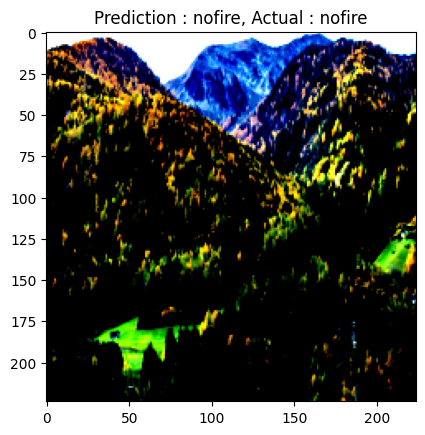

In [7]:
import matplotlib.pyplot as plt

# Predict a sample image from validation set
model.eval()
model.to(device)

# get a sample image from the validation set
image, label = val_data[307] # Change the index to get a different image
image = image.to(device)

# get predictions
outputs = model(image.unsqueeze(0))
_, preds = torch.max(outputs.data, 1)

# plot the image
plt.imshow(image.cpu().permute(1, 2, 0))
plt.title(f"Prediction : {classes[preds.item()]}, Actual : {classes[label]}")
plt.show()


In [10]:
# Get precision, recall and f1 score

from sklearn.metrics import classification_report

# set model to evaluation mode
model.eval()

# move model to the device
model.to(device)

# set current loss to 0 and current number of correct predictions to 0
current_loss = 0.0
current_corrects = 0

# iterate over the dataset
for i, (inputs, labels) in enumerate(val_loader):

    # move inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(inputs)

    # calculate loss
    loss = criterion(outputs, labels)

    # update current loss
    current_loss += loss.item() * inputs.size(0)

    # get predictions
    _, preds = torch.max(outputs.data, 1)

    # update current number of correct predictions
    current_corrects += torch.sum(preds == labels.data).item()

# calculate average loss
loss = current_loss / len(val_loader.dataset)

# calculate average accuracy
accuracy = current_corrects / len(val_loader.dataset)

# print loss and accuracy
print(f"Test Loss : {loss}. Test Accuracy : {accuracy}")

# get predictions
y_pred = []
y_true = []
for i, (inputs, labels) in enumerate(val_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    y_pred.extend(preds.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

# print classification report
print(classification_report(y_true, y_pred, target_names=classes))


Test Loss : 0.6227381798758436. Test Accuracy : 0.6940298507462687
              precision    recall  f1-score   support

        fire       0.63      0.51      0.57       156
      nofire       0.72      0.81      0.76       246

    accuracy                           0.69       402
   macro avg       0.68      0.66      0.66       402
weighted avg       0.69      0.69      0.69       402

